## **Load Data**

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fernando2rad/x-ray-lung-diseases-images-9-classes")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/x-ray-lung-diseases-images-9-classes


In [2]:
import os

# Check available files and directories
os.listdir('/kaggle/input/')


['x-ray-lung-diseases-images-9-classes']

## **Preprocessing**

In [3]:
# Preprocessing

import cv2
import numpy as np
import os
from tqdm import tqdm

# Function to apply CLAHE and Gamma Correction
def apply_clahe_and_gamma_correction(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  # CLAHE
    img_clahe = clahe.apply(img)

    gamma = 1.2  # Adjust this for brightness and contrast
    img_gamma = np.array(255 * (img_clahe / 255) ** gamma, dtype='uint8')  # Gamma correction
    return img_gamma

# Function to preprocess images (resize, CLAHE, Gamma)
def preprocess_images_with_augmentation(source_folder, target_folder, img_size=(224, 224)):
    categories = os.listdir(source_folder)
    for category in categories:
        img_paths = os.listdir(os.path.join(source_folder, category))
        os.makedirs(os.path.join(target_folder, category), exist_ok=True)
        for img_name in tqdm(img_paths, desc=f"Processing {category}"):
            img_path = os.path.join(source_folder, category, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
            img_resized = cv2.resize(img, img_size)  # Resize image
            img_preprocessed = apply_clahe_and_gamma_correction(img_resized)
            img_preprocessed = img_preprocessed / 255.0  # Normalize

            # Save preprocessed image

            cv2.imwrite(os.path.join(target_folder, category, img_name), img_preprocessed)

# Usage
source_dir = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
target_dir = '/kaggle/processed/x-ray-lung-diseases-images'
preprocess_images_with_augmentation(source_dir, target_dir)



Processing 04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia): 100%|██████████| 644/644 [00:08<00:00, 72.71it/s]
Processing 02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema): 100%|██████████| 678/678 [00:08<00:00, 79.57it/s]
Processing 03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio): 100%|██████████| 629/629 [00:06<00:00, 101.03it/s]
Processing 08 Alterações do Tórax (Atelectasias, Malformações, Agenesia, Hipoplasias): 100%|██████████| 544/544 [00:04<00:00, 115.81it/s]
Processing 06 Lesões Encapsuladas (Abscessos, Nódulos, Cistos, Massas Tumorais, Metastases): 100%|██████████| 658/658 [00:05<00:00, 121.38it/s]
Processing 05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose): 100%|██████████| 594/594 [00:04<00:00, 118.95it/s]
Processing 00 Anatomia Normal: 100%|██████████| 1340/1340 [00:12<00:00, 106.99it/s]
Processing 07 Alterações de Mediastino (Pericardite, Malform

## **split_dataset**

In [4]:
##  split_dataset

import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(source_dir)

    for class_name in classes:
        class_path = os.path.join(source_dir, class_name)
        images = os.listdir(class_path)
        train_val, test = train_test_split(images, test_size=1 - (train_ratio + val_ratio), random_state=42)
        train, val = train_test_split(train_val, test_size=val_ratio / (train_ratio + val_ratio), random_state=42)

        for split_name, split_data in zip(['train', 'val', 'test'], [train, val, test]):
            split_class_dir = os.path.join(output_dir, split_name, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for img in split_data:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_class_dir, img)
                shutil.copy(src, dst)

# Usage:
processed_source = '/kaggle/input/x-ray-lung-diseases-images-9-classes'
processed_output = '/kaggle/working/xray_split'
split_dataset(processed_source, processed_output)


## **Set up augmentation**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up augmentation for training

# Set up augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Random rotations
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    zoom_range=0.1,  # Zoom in/out
    horizontal_flip=True,  # Random horizontal flip
)

# Validation and test data will only be rescaled (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators for train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'train'),
    target_size=(224, 224),  # Resize all images to 256x256
    color_mode='grayscale',  # Use grayscale images as you mentioned
    class_mode='categorical',  # Multi-class classification
    batch_size=16,
    shuffle=True  # Shuffle to ensure varied batches during training
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'val'),
    target_size=(224, 224),  # Resize images to match input size of model
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=16,
    shuffle=False  # Don't shuffle validation data
)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'test'),
    target_size=(224, 224),  # Resize images to match model input size
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=16,
    shuffle=False  # No shuffling for test data
)


Found 4712 images belonging to 9 classes.
Found 1014 images belonging to 9 classes.
Found 1017 images belonging to 9 classes.


# **Model 3**

# **DenseNet Model**

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_proposed_densenet_model(input_shape=(224, 224, 1), num_classes=9, growth_rate=32):
    model = models.Sequential()

    # First dense block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))  # Initial conv layer
    model.add(layers.BatchNormalization())

    # Dense block 1
    for _ in range(3):  # Number of convolutional layers in the dense block
        model.add(layers.Conv2D(growth_rate, (3, 3), activation='relu', padding='same'))  # Add more convolutional layers
        model.add(layers.BatchNormalization())

    # Transition layer 1
    model.add(layers.Conv2D(128, (1, 1), activation='relu', padding='same'))  # Reduce channels with 1x1 conv
    model.add(layers.MaxPooling2D((2, 2)))  # Down-sample with max pooling

    # Dense block 2
    for _ in range(3):
        model.add(layers.Conv2D(growth_rate, (3, 3), activation='relu', padding='same'))
        model.add(layers.BatchNormalization())

    # Transition layer 2
    model.add(layers.Conv2D(256, (1, 1), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))  # Down-sample with max pooling

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))  # For multi-class classification

    optimizer = Adam(learning_rate=0.001)  #  learning rate

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the proposed DenseNet-like model
model = build_proposed_densenet_model(input_shape=(224, 224, 1))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 128)  │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 256)  │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   411,042,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 411,272,969 (1.53 GB)

 Trainable params: 411,272,521 (1.53 GB)

 Non-trainable params: 448 (1.75 KB)

## **Training the Model**

In [ ]:
import tensorflow as tf

# Enable memory growth for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


## **Fitting the model**

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping based on validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,          # Stop after 10 epochs without improvement
)

from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Train the model

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    batch_size=16,
    callbacks=[early_stopping]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 105s 287ms/step - accuracy: 0.1782 - loss: 47.1319 - val_accuracy: 0.3481 - val_loss: 1.9091
Epoch 2/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 69s 235ms/step - accuracy: 0.2874 - loss: 1.9169 - val_accuracy: 0.3856 - val_loss: 1.7249
Epoch 3/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 69s 235ms/step - accuracy: 0.3015 - loss: 1.8455 - val_accuracy: 0.4290 - val_loss: 1.5972
Epoch 4/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 69s 235ms/step - accuracy: 0.3502 - loss: 1.7858 - val_accuracy: 0.3994 - val_loss: 1.6011
Epoch 5/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 70s 235ms/step - accuracy: 0.3845 - loss: 1.6893 - val_accuracy: 0.4882 - val_loss: 1.4727
Epoch 6/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 69s 235ms/step - accuracy: 0.3991 - loss: 1.6583 - val_accuracy: 0.5079 - val_loss: 1.4780
Epoch 7/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 69s 234ms/step - accuracy: 0.4108 - loss: 1.6571 - val_accuracy: 0.5266 - val_loss: 1.3554
Epoch 8/30
295/295 ━━━━━━━━━━━━━━━━━━━━ 69s 235ms/step - accuracy: 0.4385 - loss:

## **Evaluation**

In [11]:
# Evaluation

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.6346 - loss: 1.0893
Test accuracy: 0.6194690465927124


## **Classification report**

In [12]:
# Classification report

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test data
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator)  # Predicted labels
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Classification report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))




64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.62      0.70       202
           1       0.48      0.85      0.62       160
           2       0.50      0.66      0.57       102
           3       0.91      0.32      0.47        95
           4       0.44      0.59      0.50        97
           5       0.58      0.46      0.51        90
           6       0.64      0.49      0.56        99
           7       0.89      0.79      0.84        90
           8       0.98      0.66      0.79        82

    accuracy                           0.62      1017
   macro avg       0.69      0.60      0.62      1017
weighted avg       0.68      0.62      0.62      1017



## **Confusion matrix**

Confusion Matrix:
 [[125  63   3   0  10   1   0   0   0]
 [  1 136   5   0   8   2   6   2   0]
 [  8  12  67   1  11   1   2   0   0]
 [  4   9  11  30  14  21   6   0   0]
 [  9  10   7   1  57   1   8   3   1]
 [  6  11   3   1  19  41   6   3   0]
 [  3  21  12   0  10   3  49   1   0]
 [  0  15   2   0   1   1   0  71   0]
 [  0   5  23   0   0   0   0   0  54]]


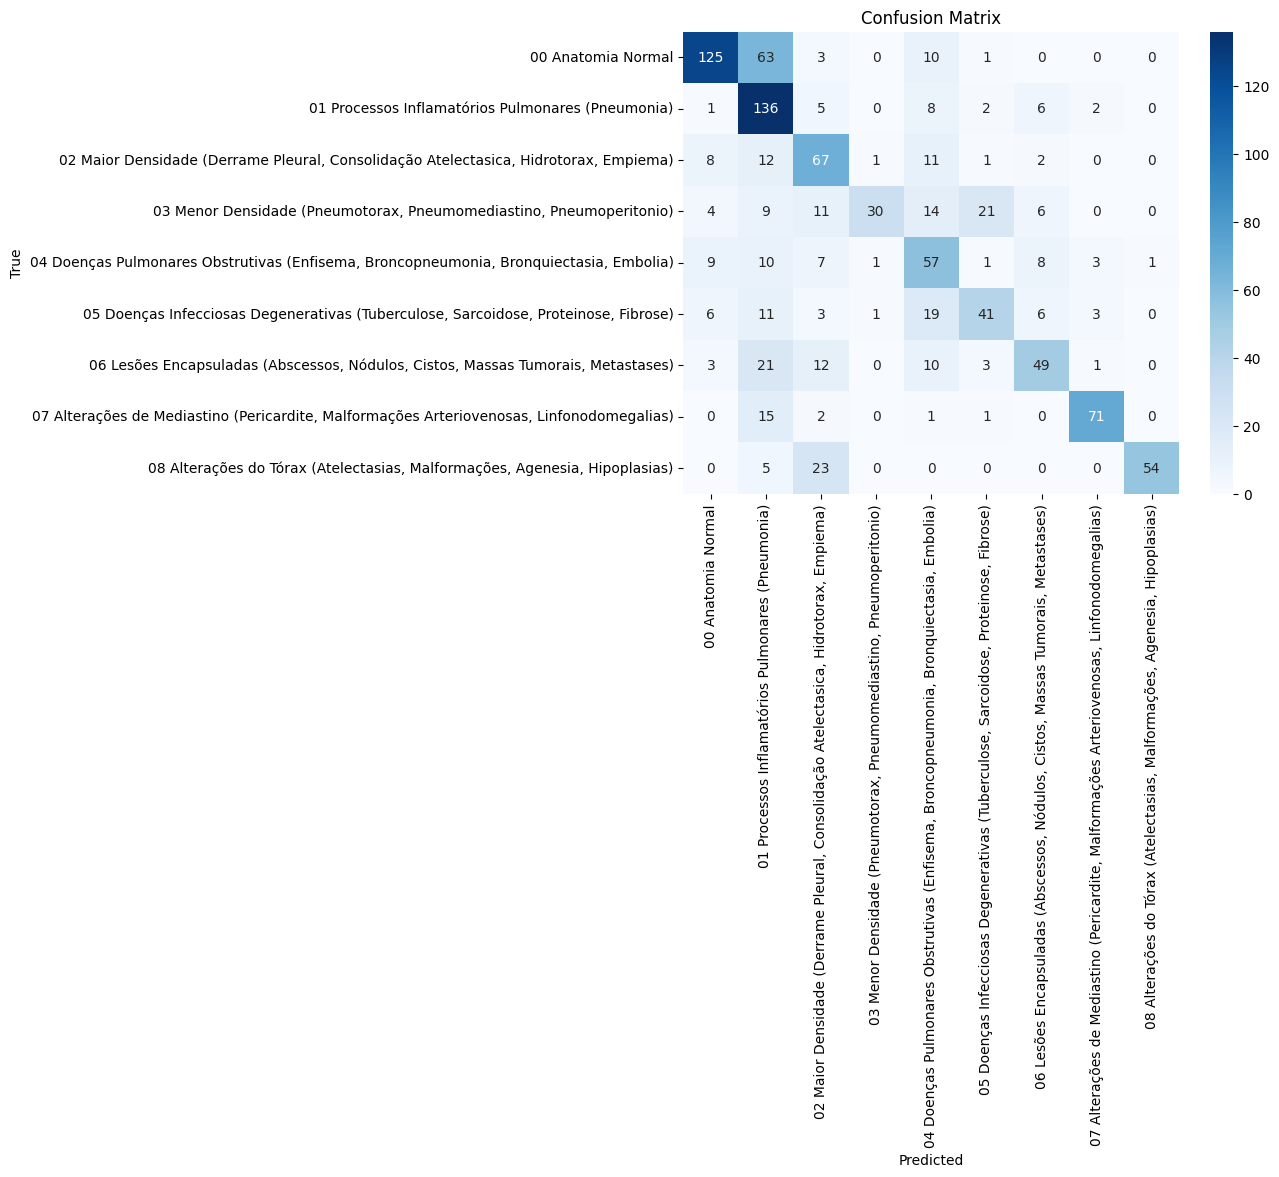

In [13]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **Plot training and validation accuracy and loss**

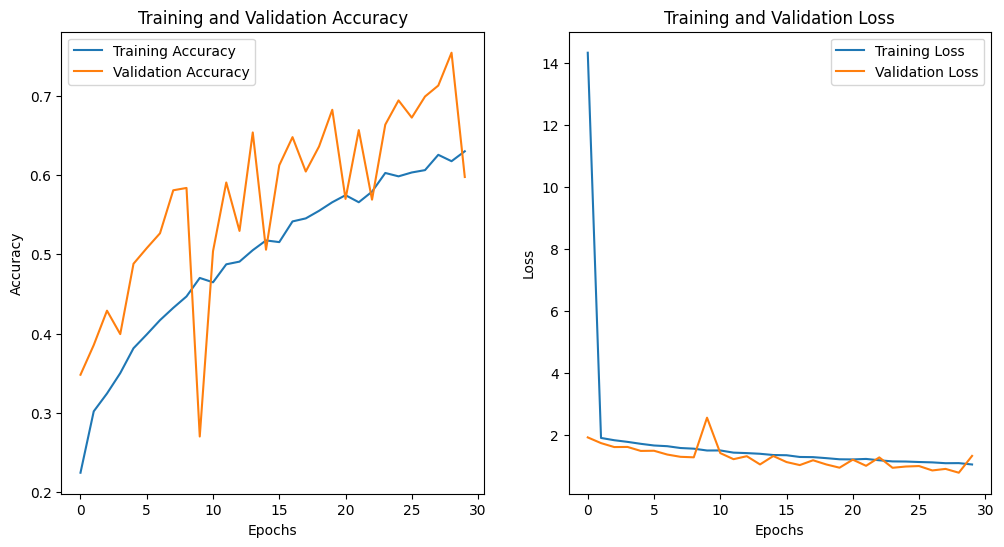

In [14]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


# ***Interpetability***

## **lime**

In [15]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7e12c608661d9636e2547ecd41d470dcadaccdfa384b4055308e6ae7e9baf486
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━

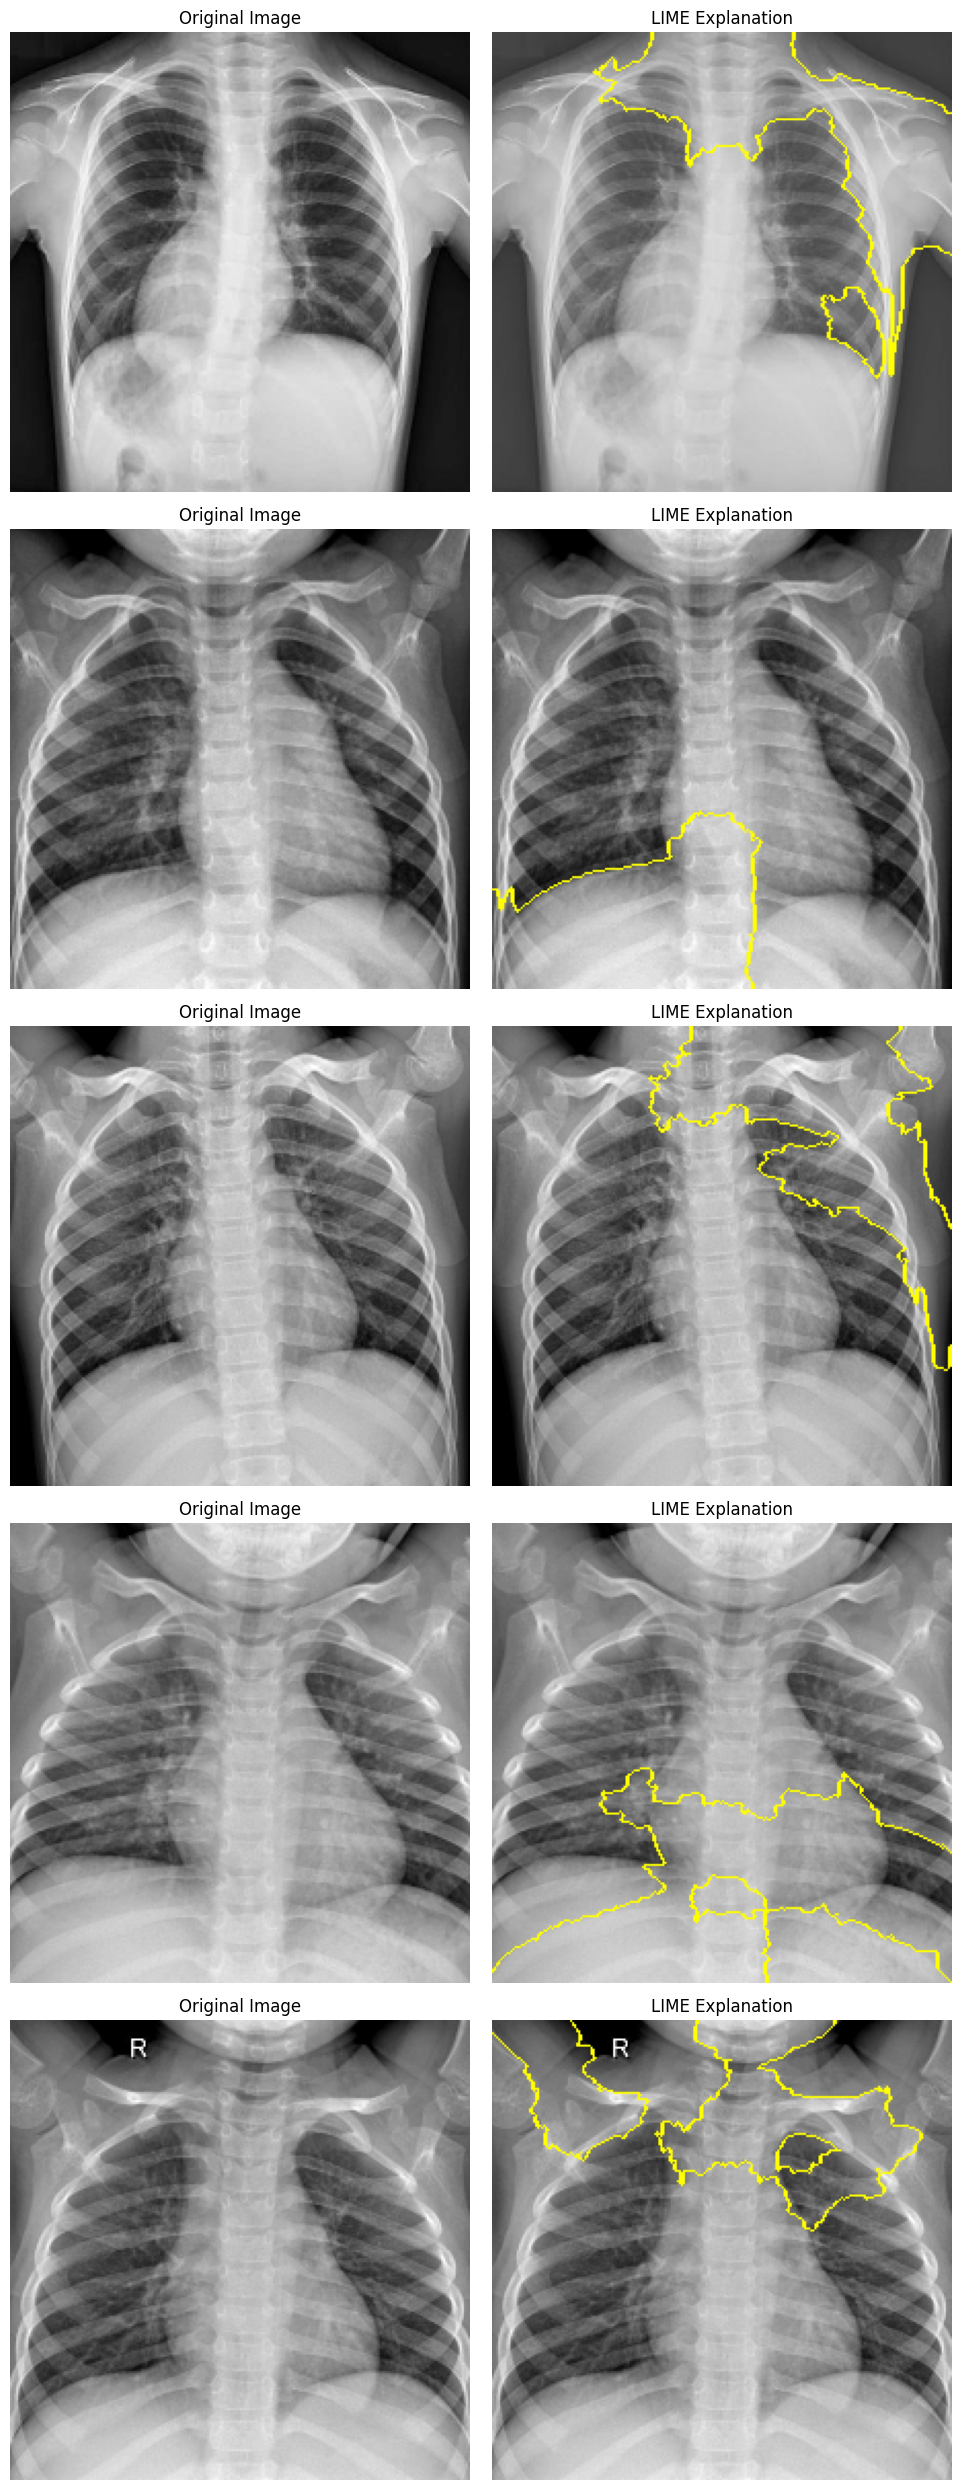

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import tensorflow as tf


def predict_fn(images_rgb):
    # Convert the images from RGB to grayscale using the luminance formula
    images_gray = np.dot(images_rgb[..., :3], [0.2989, 0.5870, 0.1140])  # RGB -> Grayscale
    images_gray = np.expand_dims(images_gray, axis=-1)  # Add a channel dimension for grayscale
    return model.predict(images_gray)

# Initialize LIME explainer
explainer = LimeImageExplainer()

# Get a batch of test images
images, labels = next(test_generator)
images = images[:5]  # Take the first 5 images for explanation

# Prepare the plot for displaying images and explanations
fig, axes = plt.subplots(len(images), 2, figsize=(10, 5 * len(images)))

for i, img_gray in enumerate(images):
    # Convert grayscale image to fake RGB format for LIME (3 channels)
    img_rgb = np.repeat(img_gray, 3, axis=2)  # Convert grayscale to RGB format


    explanation = explainer.explain_instance(

        img_rgb,  # Input image (fake RGB)
        predict_fn,  # The prediction function that returns model output
        top_labels=1,  # Top 1 label to explain
        hide_color=0,  # Don't hide the original image's color (for the explanation)
        num_samples=500  # Number of perturbed samples to generate for explanation
    )


    # Get the explanation for the top predicted class
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,  # Focus on positive contributions
        num_features=5,  # Display the top 5 features (superpixels)
        hide_rest=False  # Don't hide other parts of the image
    )


    # Plot original grayscale image
    axes[i, 0].imshow(img_gray.squeeze(), cmap='gray')  # Squeeze to remove extra dimension
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')  # Hide axis for cleaner display

    # Plot the LIME explanation (superpixels with boundaries)
    axes[i, 1].imshow(mark_boundaries(temp, mask))  # Overlay the explanation with boundaries
    axes[i, 1].set_title("LIME Explanation")
    axes[i, 1].axis('off')  # Hide axis for cleaner display

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()



## **Shap**

Model requires input shape: (None, 224, 224, 1)
Verified background shape: (5, 224, 224, 1)


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(5, 224, 224, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(10, 224, 224, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 224, 224, 1)

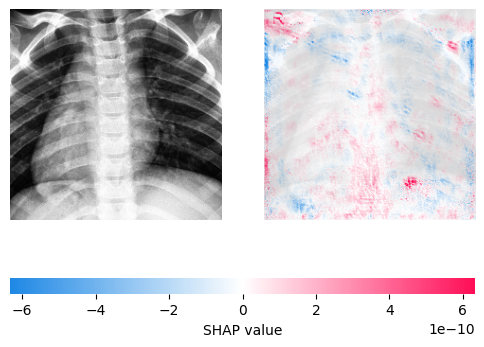

In [18]:
import os
import numpy as np
import tensorflow as tf
import shap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# ========== MEMORY AND GPU CONFIGURATION ==========
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
tf.keras.backend.clear_session()


# ========== MODEL INPUT VERIFICATION ==========
MODEL_INPUT_SIZE = model.input_shape[1:3]  # (224, 224) shape
print(f"Model requires input shape: (None, {MODEL_INPUT_SIZE[0]}, {MODEL_INPUT_SIZE[1]}, 1)")


# ========== DATA PREPARATION ==========
def preprocess_image(img_array):
    """Preprocess image for SHAP"""
    img_array = img_array / 255.0  # Normalize to [0, 1]
    return np.expand_dims(img_array, axis=0)  # Shape: (1, 224, 224, 1)



# Get a batch of images from the test_generator
test_images, test_labels = next(test_generator)


# Choose the first image from the batch
img_array = test_images[0]  # Take the first image (grayscale)



# Preprocess the image for SHAP
img_array = preprocess_image(img_array)



# Prepare background data (subset of test data)
background, _ = next(test_generator)
background = tf.image.resize(background, MODEL_INPUT_SIZE).numpy()[:5]  # Use only 5 samples for background
print("Verified background shape:", background.shape)



# ========== SHAP COMPUTATION ==========
def compute_shap_values():
    """Compute SHAP values"""
    try:
        # Use CPU if GPU is out of memory
        with tf.device('/CPU:0'):
            explainer = shap.DeepExplainer(model, background)
            return explainer.shap_values(img_array)
    except Exception as e:
        print(f"DeepExplainer failed: {str(e)}")
        return None

shap_values = compute_shap_values()

if shap_values is None:
    raise RuntimeError("SHAP computation failed")



# ========== STANDARD SHAP VISUALIZATION ==========

shap.image_plot(shap_values, img_array)


## **Saliency Map**

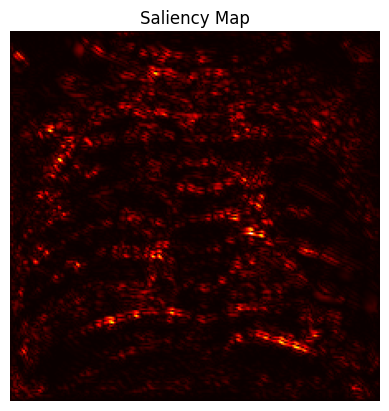

In [19]:
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_saliency_map(model, img_array):
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        top_class = preds[:, tf.argmax(preds[0])]

    grads = tape.gradient(top_class, img_tensor)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    plt.imshow(saliency, cmap='hot')
    plt.title('Saliency Map')
    plt.axis('off')
    plt.show()

# Get a single image from the test generator
img, _ = next(test_generator)
img = img[0:1]  # Pick 1 sample

plot_saliency_map(model, img)


## **Integrated Gradients**

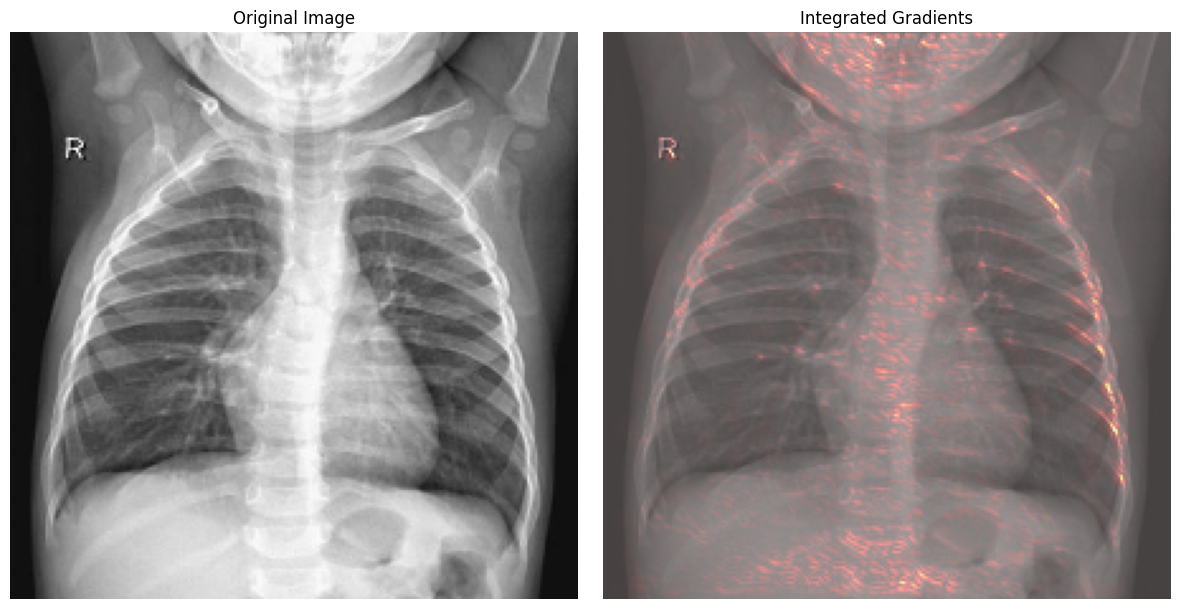

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# function integrated_gradients

def integrated_gradients(model, img_array, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros(img_array.shape).astype(np.float32)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline_tensor = tf.convert_to_tensor(baseline, dtype=tf.float32)

    interpolated_images = [baseline_tensor + (float(i)/steps)*(img_tensor-baseline_tensor) for i in range(steps + 1)]
    grads = []
    for img in interpolated_images:
        with tf.GradientTape() as tape:
            tape.watch(img)
            pred = model(img)
            top_class = pred[:, tf.argmax(pred[0])]
        grad = tape.gradient(top_class, img)
        grads.append(grad.numpy())

    avg_grads = np.mean(grads, axis=0)
    integrated_grads = (img_tensor - baseline_tensor) * avg_grads
    return integrated_grads.numpy()

# Get a single image from the test generator
img, _ = next(test_generator)
img = img[0:1]

# Compute Integrated Gradients
int_grads = integrated_gradients(model, img)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(img.squeeze(), cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Integrated Gradients overlay
ax[1].imshow(img.squeeze(), cmap='gray', alpha=0.6)
ax[1].imshow(np.abs(int_grads.squeeze()), cmap='hot', alpha=0.4)
ax[1].set_title('Integrated Gradients')
ax[1].axis('off')

plt.tight_layout()
plt.show()


# **Comarison with pretrained model**

# **Load EfficientNetB0 with Pretrained Weights**

## **Intialize the Model**

In [9]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def load_efficientnet_model(input_shape=(224, 224, 3), num_classes=9):
    # Load EfficientNetB0 with pretrained weights
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze the last few layers of EfficientNetB0
    for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])

    # Compile the model with a lower learning rate for fine-tuning
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the EfficientNet model with enhanced fine-tuning
model = load_efficientnet_model(input_shape=(224, 224, 3), num_classes=9)

# Display model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,820 (16.71 MB)

 Trainable params: 4,337,797 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [10]:
import tensorflow as tf

# Train the EfficientNetB0 model with your dataset
history = model.fit(
    train_generator,  #  train_generator
    epochs=10,  # Adjust epochs
    validation_data=val_generator,  # val_generator
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)




/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 156s 273ms/step - accuracy: 0.1398 - loss: 6.4665 - val_accuracy: 0.1065 - val_loss: 6.3496
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 38s 129ms/step - accuracy: 0.3259 - loss: 6.0367 - val_accuracy: 0.1568 - val_loss: 6.2190
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 39s 133ms/step - accuracy: 0.3815 - loss: 5.7440 - val_accuracy: 0.3481 - val_loss: 5.7800
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.4577 - loss: 5.4970 - val_accuracy: 0.4132 - val_loss: 5.6287
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 47s 160ms/step - accuracy: 0.5261 - loss: 5.2621 - val_accuracy: 0.4586 - val_loss: 5.3447
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 33s 110ms/step - accuracy: 0.5956 - loss: 5.0050 - val_accuracy: 0.5128 - val_loss: 5.2917
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.6357 - loss: 4.8078 - val_accuracy: 0.2535 - val_loss: 5.5677
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 32s 110ms/step - accuracy: 0.6729 - loss: 

In [11]:

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)  # test_generator
print(f"Test Accuracy: {test_acc}")


 3/64 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8819 - loss: 4.6134

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.6573 - loss: 4.9751
Test Accuracy: 0.5004916191101074


In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step
                                                                                           precision    recall  f1-score   support

                                                                       00 Anatomia Normal       0.85      0.74      0.79       202
                                        01 Processos Inflamatórios Pulmonares (Pneumonia)       0.40      0.81      0.53       160
     02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)       0.42      0.41      0.42       102
                      03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)       0.43      0.61      0.51        95
   04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)       0.41      0.15      0.22        97
      05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)       0.37      0.54      0.44        90
         06 Lesões Encapsuladas (Abscess

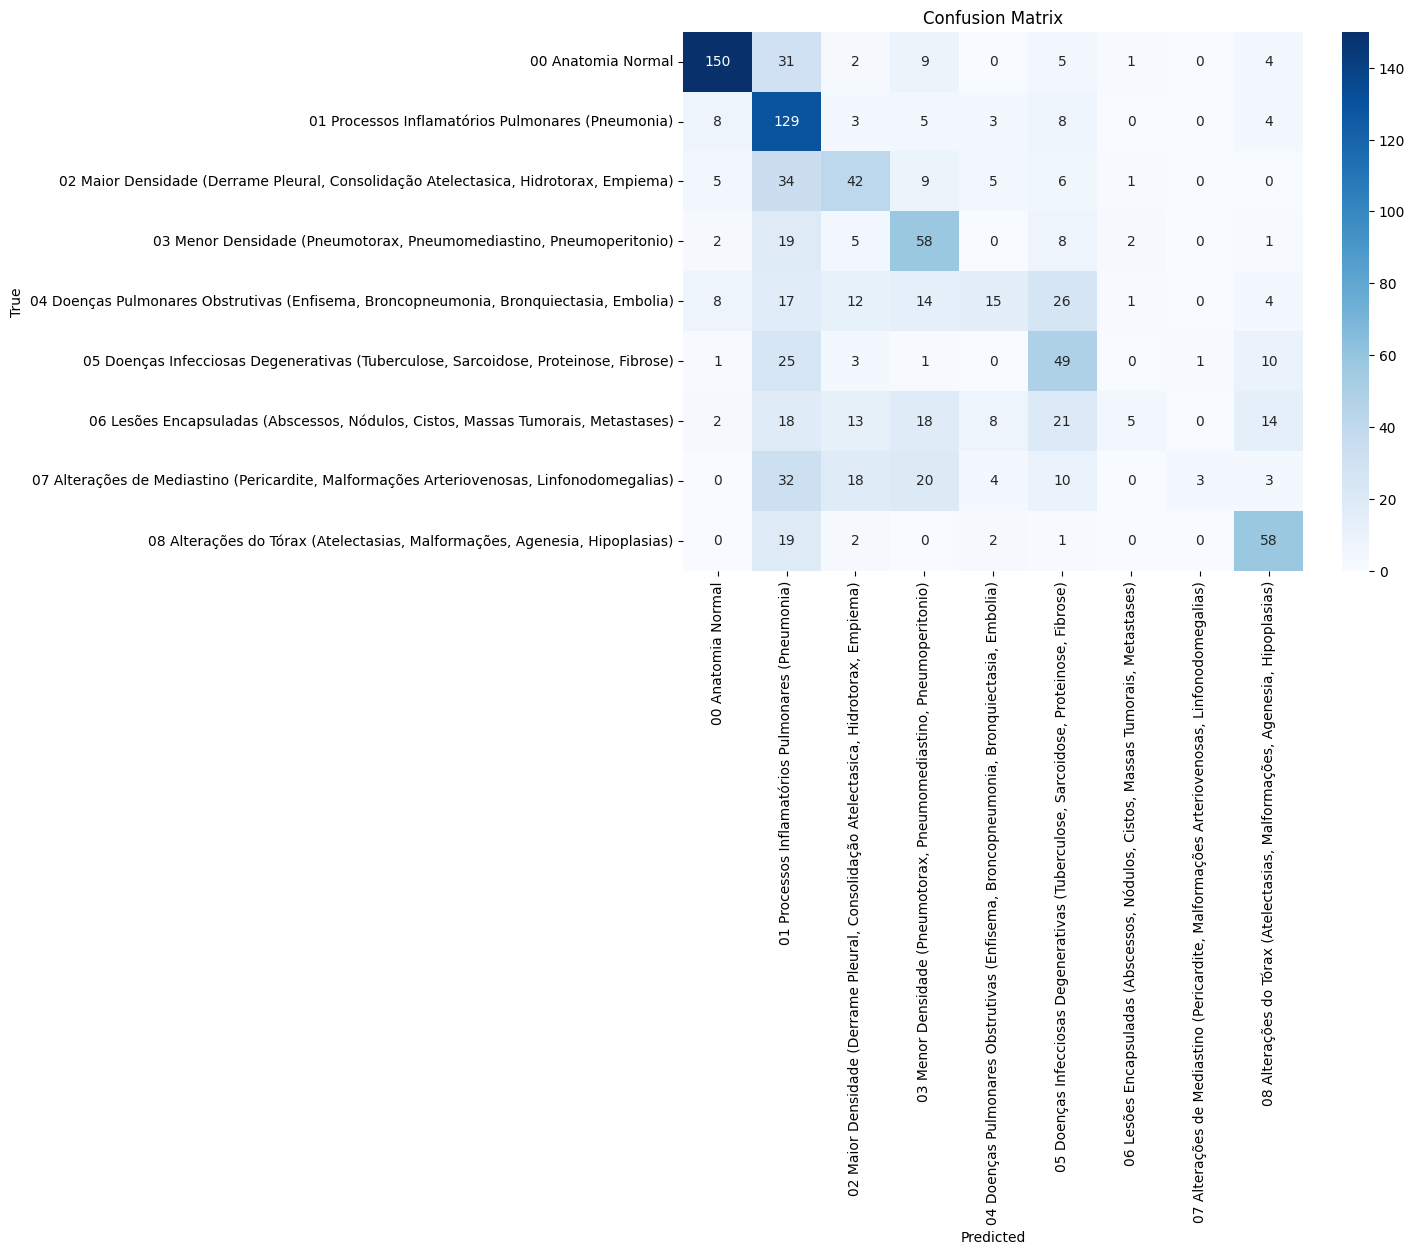

In [13]:

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# **Interpetability**

## **Lime**

In [24]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=cd1f48ce07a1fe12ec2dcfc51373a776e81952401bd2da268abdd2faee7910bb
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

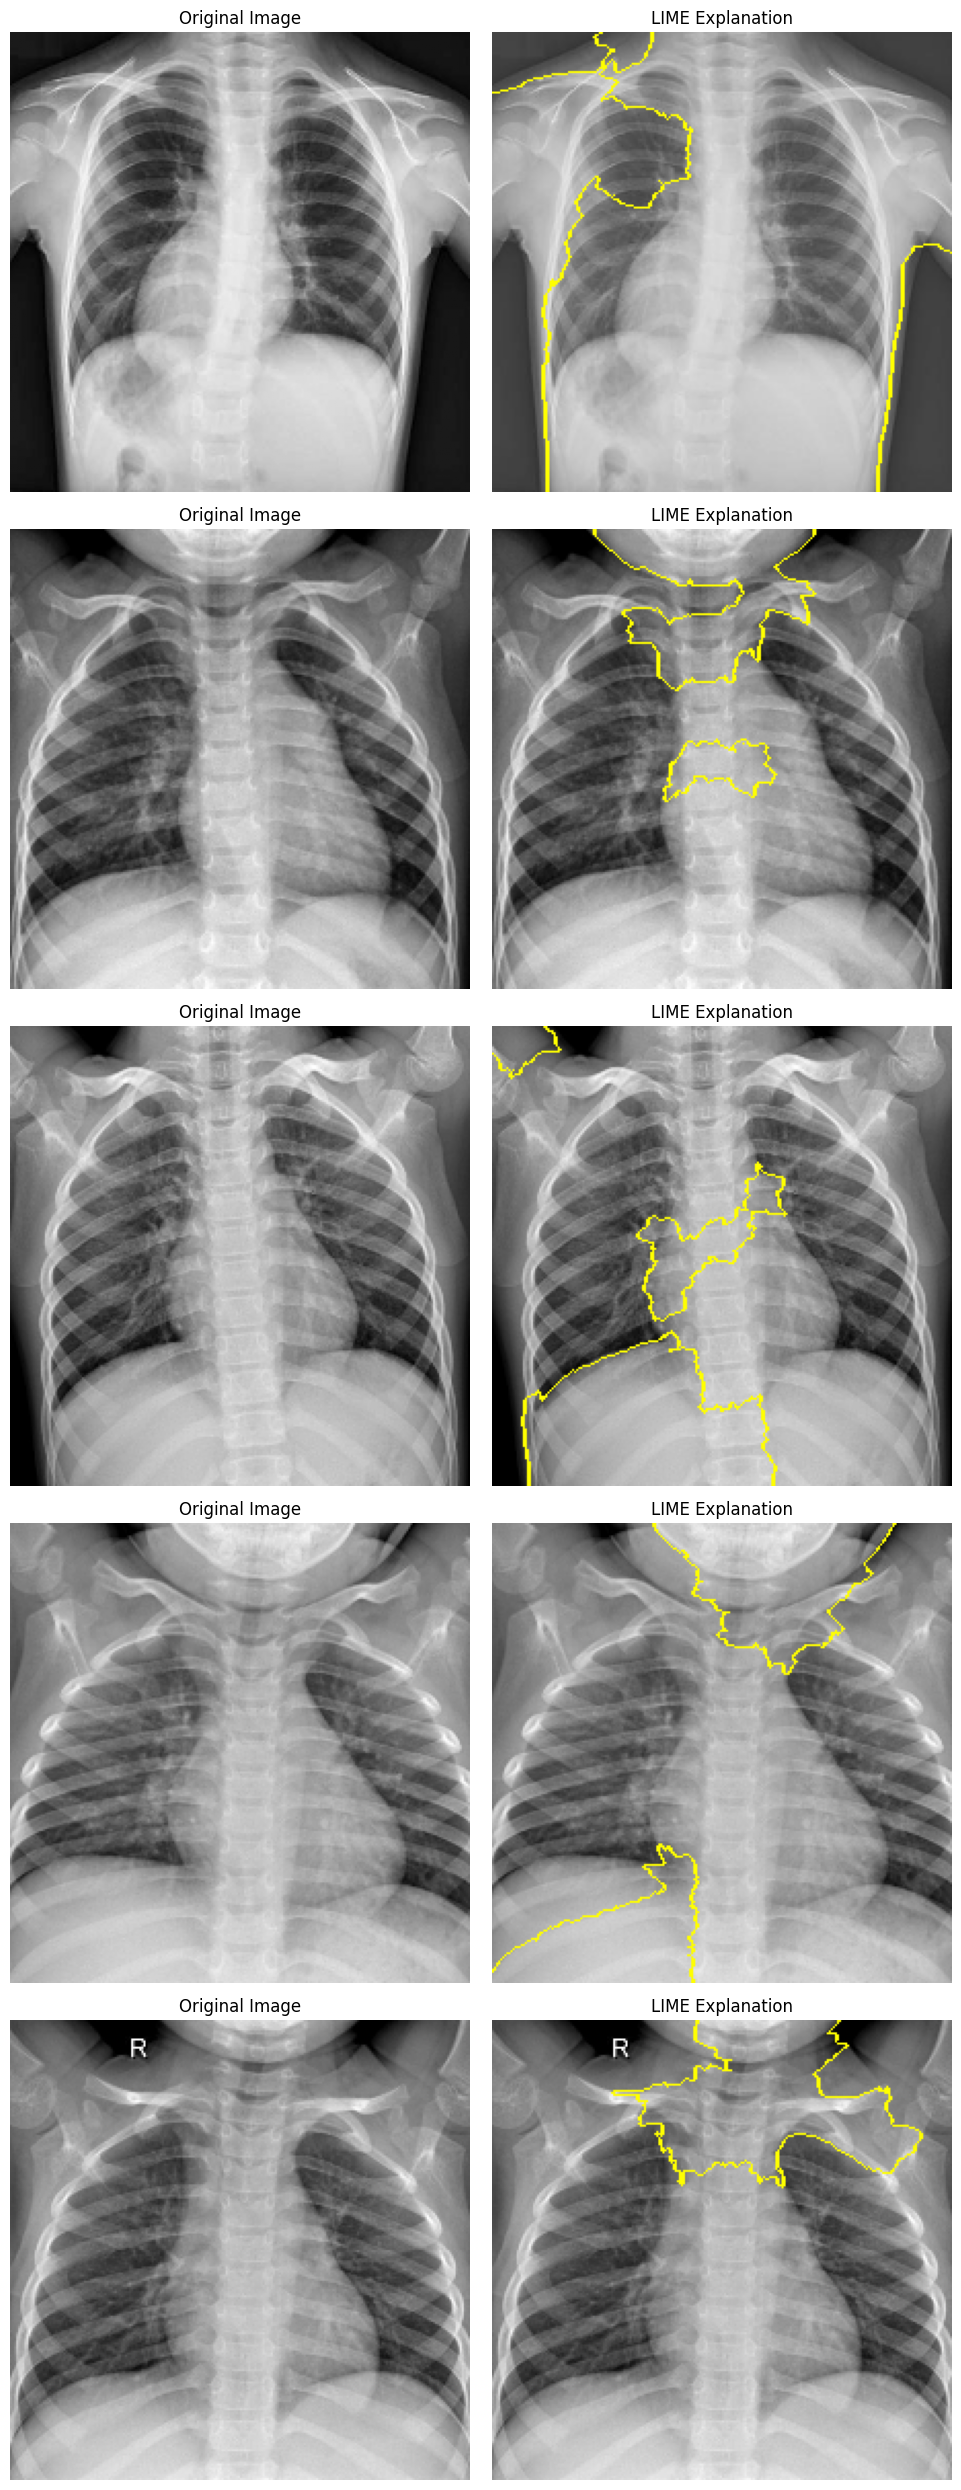

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import tensorflow as tf

# Define the correct prediction function for LIME
def predict_fn(images_rgb):
    # Convert the images from RGB to grayscale using the luminance formula
    images_gray = np.dot(images_rgb[..., :3], [0.2989, 0.5870, 0.1140])  # RGB -> Grayscale
    images_gray = np.expand_dims(images_gray, axis=-1)  # Add a channel dimension for grayscale
    return model.predict(images_gray)

# Initialize LIME explainer
explainer = LimeImageExplainer()

# Get a batch of test images
images, labels = next(test_generator)
images = images[:5]  # Take the first 5 images for explanation

# Prepare the plot for displaying images and explanations
fig, axes = plt.subplots(len(images), 2, figsize=(10, 5 * len(images)))

for i, img_gray in enumerate(images):
    # Convert grayscale image to fake RGB format for LIME (3 channels)
    img_rgb = np.repeat(img_gray, 3, axis=2)  # Convert grayscale to RGB format

    # Explain the image using LIME
    explanation = explainer.explain_instance(
        img_rgb,  # Input image (fake RGB)
        predict_fn,  # The prediction function that returns model output
        top_labels=1,  # Top 1 label to explain
        hide_color=0,  # Don't hide the original image's color (for the explanation)
        num_samples=500  # Number of perturbed samples to generate for explanation
    )

    # Get the explanation for the top predicted class
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,  # Focus on positive contributions
        num_features=5,  # Display the top 5 features (superpixels)
        hide_rest=False  # Don't hide other parts of the image
    )


    # Plot original grayscale image
    axes[i, 0].imshow(img_gray.squeeze(), cmap='gray')  # Squeeze to remove extra dimension
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')  # Hide axis for cleaner display

    # Plot the LIME explanation (superpixels with boundaries)
    axes[i, 1].imshow(mark_boundaries(temp, mask))  # Overlay the explanation with boundaries
    axes[i, 1].set_title("LIME Explanation")
    axes[i, 1].axis('off')  # Hide axis for cleaner display

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()



# **Inception V3**

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os

In [14]:
# Load InceptionV3 with pretrained weights
def load_inceptionv3_model(input_shape=(224, 224, 3), num_classes=9):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Unfreeze the last few layers of InceptionV3 for fine-tuning
    for layer in base_model.layers[-20:]:  # Unfreeze last 20 layers for fine-tuning
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])

    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# Set up augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Random rotations
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    zoom_range=0.1,  # Zoom in/out
    horizontal_flip=True  # Random horizontal flip
)

# Validation and test data will only be rescaled (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up data generators for train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'train'),
    target_size=(224, 224),  # Resize all images to 224x224
    color_mode='rgb',  # Load images as RGB (even though they are grayscale, will convert to RGB)
    class_mode='categorical',  # Multi-class classification
    batch_size=16,
    shuffle=True  # Shuffle to ensure varied batches during training
)

val_generator = val_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'val'),
    target_size=(224, 224),  # Resize images to match input size of model
    color_mode='rgb',  # Load images as RGB (even though they are grayscale, will convert to RGB)
    class_mode='categorical',
    batch_size=16,
    shuffle=False  # Don't shuffle validation data
)

test_generator = test_datagen.flow_from_directory(
    directory=os.path.join(processed_output, 'test'),
    target_size=(224, 224),  # Resize images to match model input size
    color_mode='rgb',  # Load images as RGB (even though they are grayscale, will convert to RGB)
    class_mode='categorical',
    batch_size=16,
    shuffle=False  # No shuffling for test data
)

# Initialize the InceptionV3 model with enhanced fine-tuning
model = load_inceptionv3_model(input_shape=(224, 224, 3), num_classes=9)

# Display model summary
model.summary()

Found 4712 images belonging to 9 classes.
Found 1014 images belonging to 9 classes.
Found 1017 images belonging to 9 classes.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,329,641 (85.18 MB)

 Trainable params: 22,295,209 (85.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [16]:
# Train the model with your dataset
history = model.fit(
    train_generator,  # train_generator
    epochs=10,  # Adjust epochs
    validation_data=val_generator,  # val_generator
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 206s 420ms/step - accuracy: 0.2192 - loss: 2.1343 - val_accuracy: 0.3905 - val_loss: 1.7012
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 75s 254ms/step - accuracy: 0.4680 - loss: 1.5527 - val_accuracy: 0.6736 - val_loss: 1.1302
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 77s 260ms/step - accuracy: 0.6124 - loss: 1.2116 - val_accuracy: 0.7742 - val_loss: 0.8288
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 75s 252ms/step - accuracy: 0.7091 - loss: 0.9201 - val_accuracy: 0.8195 - val_loss: 0.6307
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 75s 253ms/step - accuracy: 0.7553 - loss: 0.7636 - val_accuracy: 0.8511 - val_loss: 0.5025
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 74s 252ms/step - accuracy: 0.8174 - loss: 0.5919 - val_accuracy: 0.8945 - val_loss: 0.3811
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 75s 256ms/step - accuracy: 0.8440 - loss: 0.4962 - val_accuracy: 0.9162 - val_loss: 0.2938
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 84s 284ms/step - accuracy: 0.8735 - loss: 

In [17]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)  # test_generator
print(f"Test Accuracy: {test_acc}")



64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9555 - loss: 0.1536
Test Accuracy: 0.9616519212722778


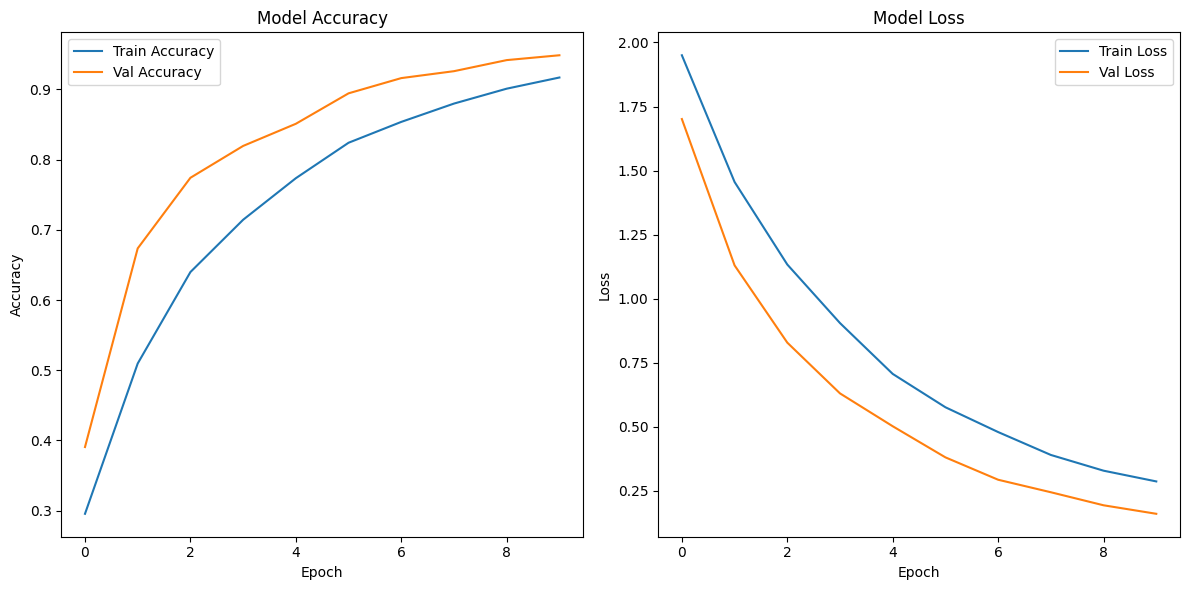

In [18]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss for both models
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history)


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [21]:
# Get the predicted labels
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print the classification report
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))



64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step
                                                                                           precision    recall  f1-score   support

                                                                       00 Anatomia Normal       0.94      0.97      0.96       202
                                        01 Processos Inflamatórios Pulmonares (Pneumonia)       0.94      0.90      0.92       160
     02 Maior Densidade (Derrame Pleural, Consolidação Atelectasica, Hidrotorax, Empiema)       0.98      0.97      0.98       102
                      03 Menor Densidade (Pneumotorax, Pneumomediastino, Pneumoperitonio)       0.98      0.98      0.98        95
   04 Doenças Pulmonares Obstrutivas (Enfisema, Broncopneumonia, Bronquiectasia, Embolia)       0.94      0.94      0.94        97
      05 Doenças Infecciosas Degenerativas (Tuberculose, Sarcoidose, Proteinose, Fibrose)       0.94      0.94      0.94        90
         06 Lesões Encapsuladas (Abscessos

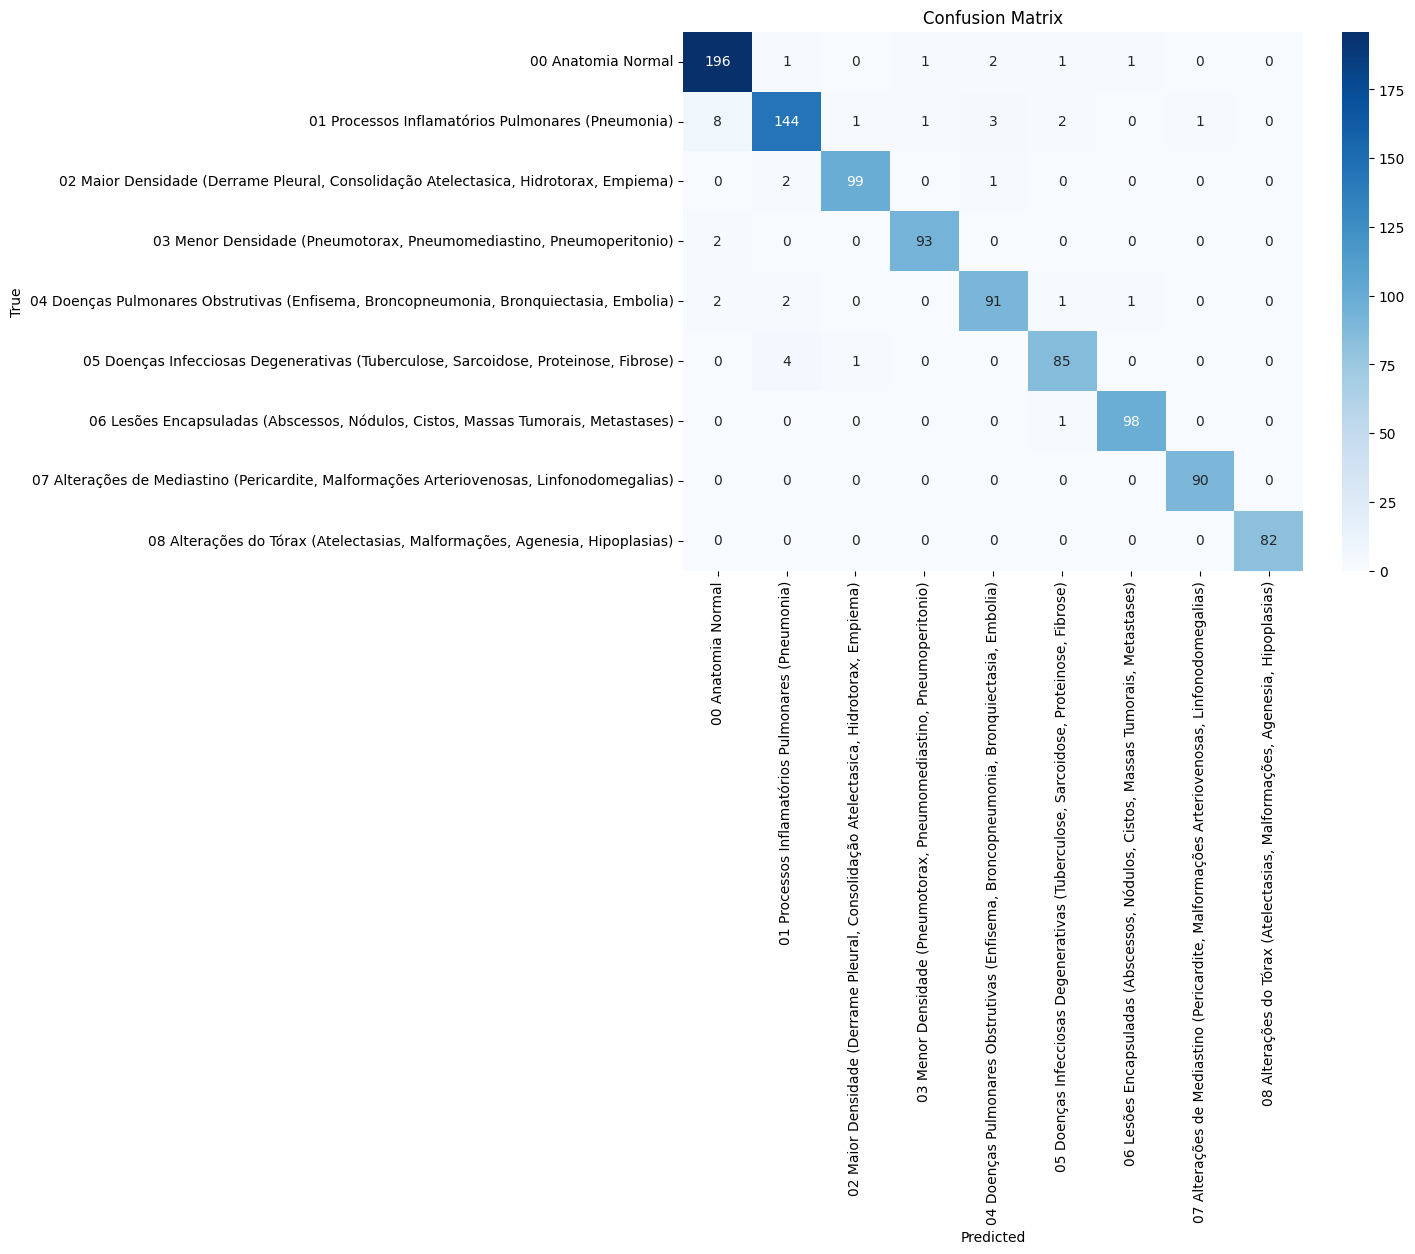

In [22]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# **Interpetability**

## **Lime**

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━

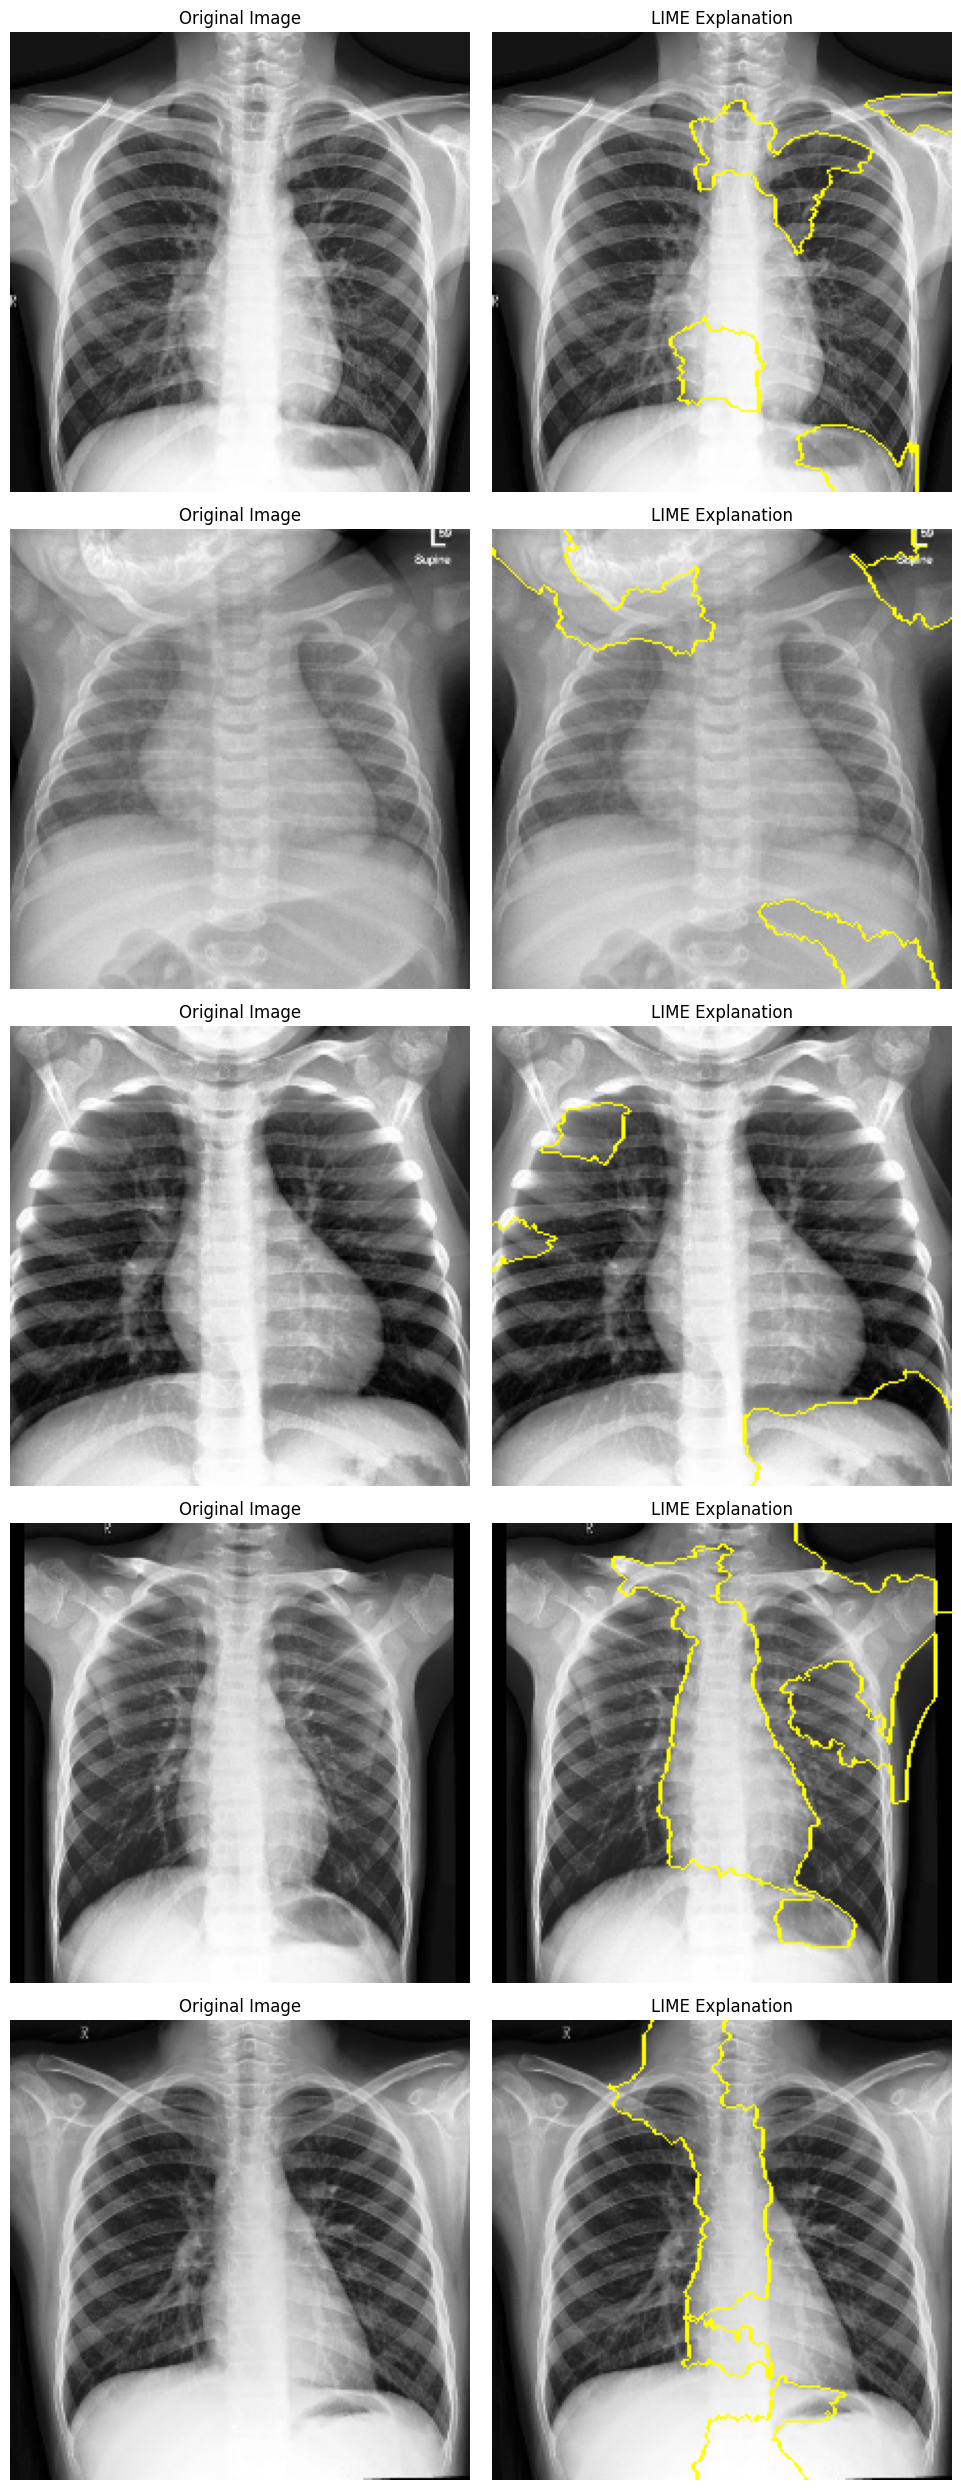

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import tensorflow as tf

# Define the correct prediction function for LIME using your pre-trained InceptionV3 model
def predict_fn(images_rgb):
    # Preprocess the images for InceptionV3 (resize and normalize)

    # Process each image individually
    processed_images = []
    for img in images_rgb:
        img_resized = tf.image.resize(img[np.newaxis, ...], (224, 224))
        img_resized = tf.keras.applications.inception_v3.preprocess_input(img_resized)
        processed_images.append(img_resized)

    processed_images = np.vstack(processed_images)  # Stack the processed images

    return model.predict(processed_images)  # Predict on the stack


# Initialize LIME explainer
explainer = LimeImageExplainer()

# Get a batch of test images
images, labels = next(test_generator)
images = images[:5]  # Take the first 5 images for explanation

# Prepare the plot for displaying images and explanations
fig, axes = plt.subplots(len(images), 2, figsize=(10, 5 * len(images)))

for i, img_gray in enumerate(images):
    # Convert grayscale image to fake RGB format for LIME (3 channels)

    img_rgb = np.stack((img_gray[:,:,0],)*3, axis=-1)

    # Explain the image using LIME
    explanation = explainer.explain_instance(
        img_rgb,  # Input image (fake RGB)
        predict_fn,  # The prediction function that returns model output
        top_labels=1,  # Top 1 label to explain
        hide_color=0,  # Don't hide the original image's color (for the explanation)
        num_samples=500  # Number of perturbed samples to generate for explanation
    )

    # Get the explanation for the top predicted class
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,  # Focus on positive contributions
        num_features=5,  # Display the top 5 features (superpixels)
        hide_rest=False  # Don't hide other parts of the image
    )

    # Plot original grayscale image
    axes[i, 0].imshow(img_gray.squeeze(), cmap='gray')  # Squeeze to remove extra dimension
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')  # Hide axis for cleaner display

    # Plot the LIME explanation (superpixels with boundaries)
    axes[i, 1].imshow(mark_boundaries(temp, mask))  # Overlay the explanation with boundaries
    axes[i, 1].set_title("LIME Explanation")
    axes[i, 1].axis('off')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## **Integrated Gradients**

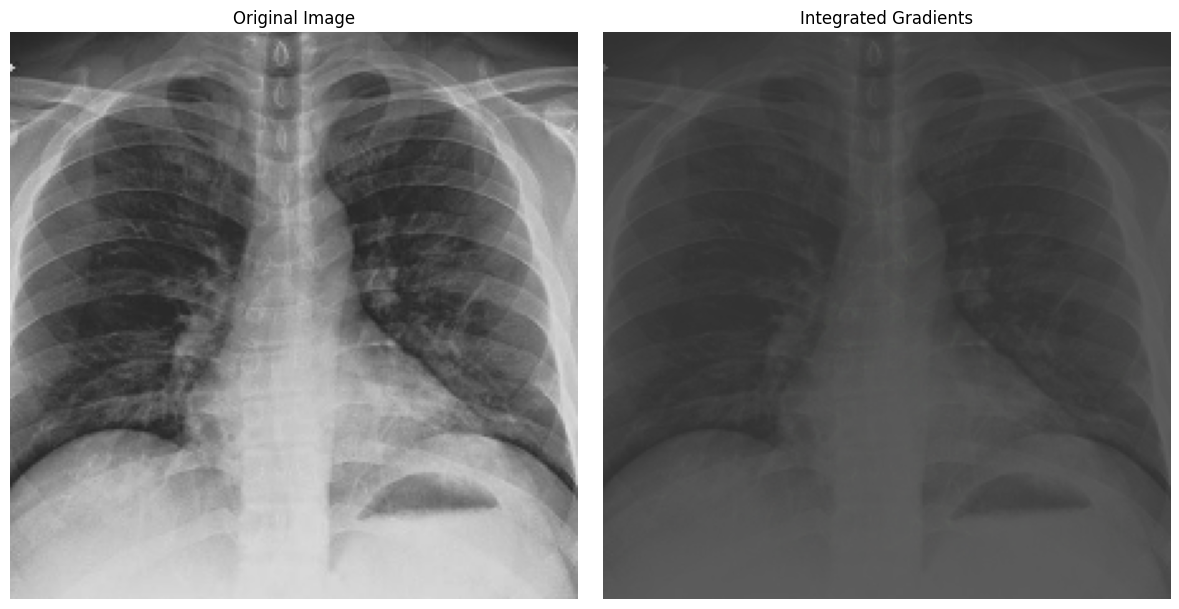

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function for Integrated Gradients
def integrated_gradients(model, img_array, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros(img_array.shape).astype(np.float32)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline_tensor = tf.convert_to_tensor(baseline, dtype=tf.float32)

    interpolated_images = [baseline_tensor + (float(i)/steps)*(img_tensor-baseline_tensor) for i in range(steps + 1)]
    grads = []
    for img in interpolated_images:
        with tf.GradientTape() as tape:
            tape.watch(img)
            pred = model(img)
            top_class = pred[:, tf.argmax(pred[0])]  # Get top predicted class
        grad = tape.gradient(top_class, img)
        grads.append(grad.numpy())

    avg_grads = np.mean(grads, axis=0)
    integrated_grads = (img_tensor - baseline_tensor) * avg_grads
    return integrated_grads.numpy()

# Get a single image from the test generator
img, _ = next(test_generator)
img = img[0:1]  # Get the first image from the batch

# Compute Integrated Gradients
int_grads = integrated_gradients(model, img)

# Plot the results with improved heatmap visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(img.squeeze(), cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Improved Integrated Gradients overlay with better transparency
ax[1].imshow(img.squeeze(), cmap='gray', alpha=0.6)
ax[1].imshow(np.abs(int_grads.squeeze()), cmap='hot', alpha=0.6)  # Adjust alpha for better visibility
ax[1].set_title('Integrated Gradients')
ax[1].axis('off')

plt.tight_layout()
plt.show()
